- Segmentación de pacientes (Clustering)
    - Objetivo: descubrir subgrupos naturales (sin target predefinido).

- Algoritmos: K-Means, DBSCAN, HDBSCAN, clustering jerárquico.
- Variables a usar: todas las numéricas (actividad, sueño, estrés, biomarcadores).
- Aplicación: identificar perfiles de riesgo o patrones de comportamiento.

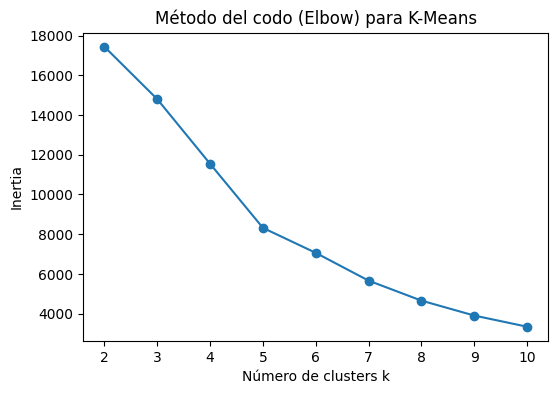

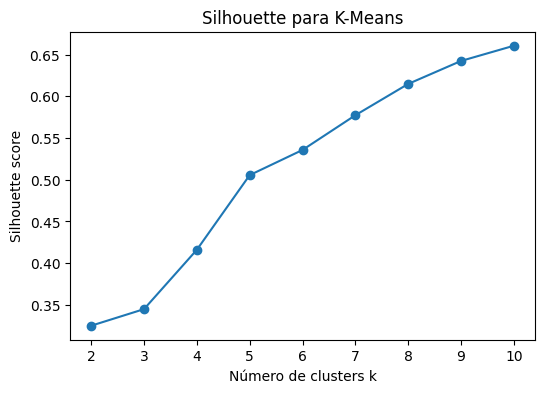

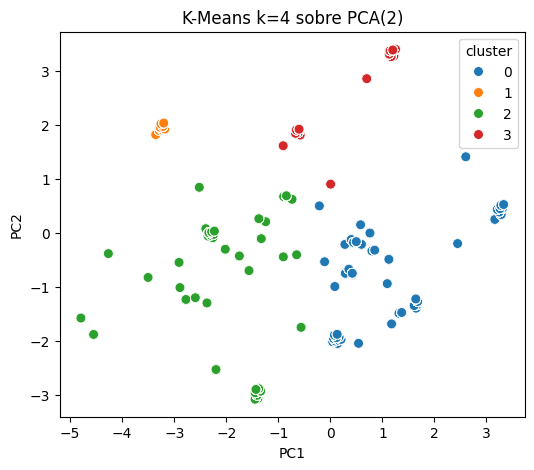

Número de clusters DBSCAN (incluye -1 como ruido): 33


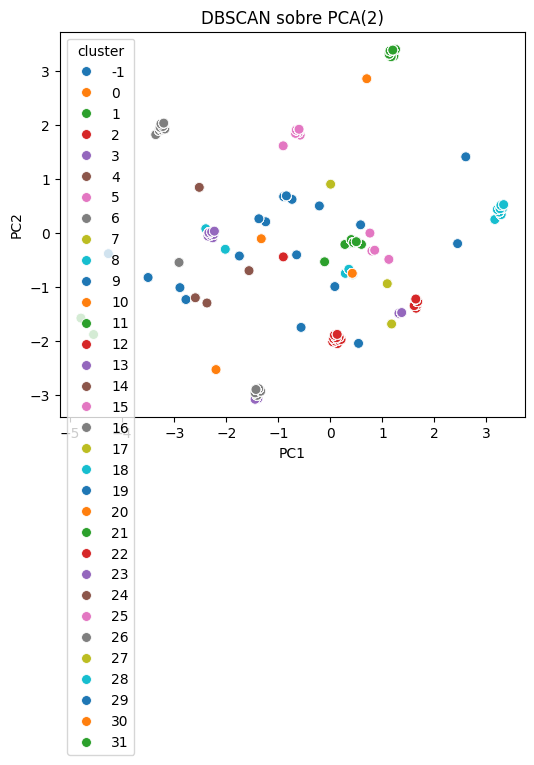

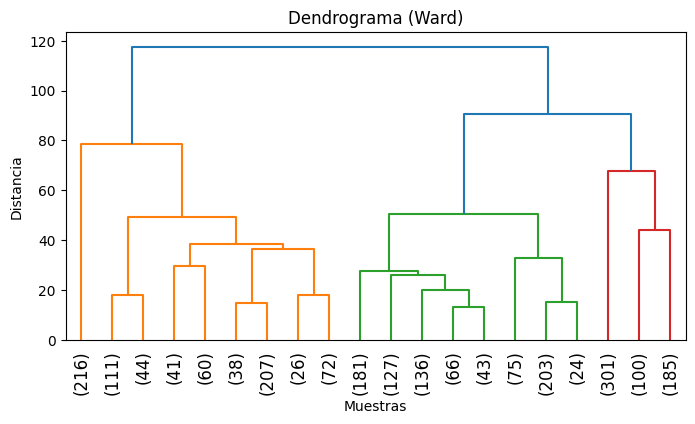

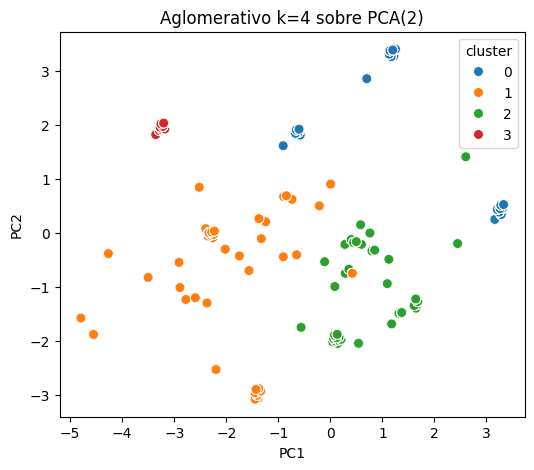

Centroides K-Means (en escala original):
         Gender        Age  Occupation  Sleep Duration  Quality of Sleep  \
0  4.876174e-01  41.274125    2.126388        7.698634          8.164816   
1  1.221245e-15  49.638889    5.000000        6.074074          6.000000   
2  7.869718e-01  37.700704    4.674296        6.379049          5.994718   
3  5.315615e-02  53.102990    6.448505        7.589701          8.335548   

   Physical Activity Level  Stress Level  BMI Category  Blood Pressure  \
0                59.056362      4.273271      0.099915        8.040137   
1                90.000000      8.000000      3.000000       23.000000   
2                41.038732      7.080986      1.929577       13.413732   
3                65.265781      3.425249      2.946844       21.897010   

   Heart Rate   Daily Steps  
0   67.701110   6807.856533  
1   75.000000  10000.000000  
2   74.063380   5494.190141  
3   68.172757   6386.046512  

Media de variables por cluster:
                  Gender

In [ ]:

# ==============================
# Clustering de pacientes
# ==============================
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

# 1. Carga de datos y selección de variables numéricas
df = pd.read_csv('../data/combined_sleep_dataset.csv')
num_df = df.select_dtypes(include=['int64','float64']).drop(columns=['Sleep_disorder','Diagnosis_Confirmed'])
# (quitar Diagnosis_Confirmed si no es relevante)

# 2. Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(num_df)

# 3. Reducción a 2 componentes para visualización
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# 4. Elbow method para K-Means
inertia = []
K = range(2,11)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)
plt.figure(figsize=(6,4))
plt.plot(K, inertia, 'o-')
plt.xlabel('Número de clusters k')
plt.ylabel('Inertia')
plt.title('Método del codo (Elbow) para K-Means')
plt.show()

# 5. Silhouette para K-Means
sil = []
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    sil.append(silhouette_score(X_scaled, labels))
plt.figure(figsize=(6,4))
plt.plot(K, sil, 'o-')
plt.xlabel('Número de clusters k')
plt.ylabel('Silhouette score')
plt.title('Silhouette para K-Means')
plt.show()

# 6. K-Means final (elige k óptimo, por ejemplo k=4)
k_opt = 4
kmeans = KMeans(n_clusters=k_opt, random_state=42)
clusters_km = kmeans.fit_predict(X_scaled)
df['cluster_kmeans'] = clusters_km

# Visualizamos en PCA
plt.figure(figsize=(6,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters_km, palette='tab10', s=50)
plt.title(f'K-Means k={k_opt} sobre PCA(2)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='cluster')
plt.show()

# 7. DBSCAN
db = DBSCAN(eps=1.5, min_samples=10)
clusters_db = db.fit_predict(X_scaled)
df['cluster_dbscan'] = clusters_db
print("Número de clusters DBSCAN (incluye -1 como ruido):", len(set(clusters_db)))

# Visualización DBSCAN
plt.figure(figsize=(6,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters_db, palette='tab10', s=50)
plt.title('DBSCAN sobre PCA(2)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='cluster')
plt.show()

# 8. Clustering jerárquico
linked = linkage(X_scaled, method='ward')
plt.figure(figsize=(8,4))
dendrogram(linked, truncate_mode='lastp', p=20, leaf_rotation=90.)
plt.title('Dendrograma (Ward)')
plt.xlabel('Muestras')
plt.ylabel('Distancia')
plt.show()

# 9. Aplicar AgglomerativeClustering (por ejemplo 4 clusters)
agg = AgglomerativeClustering(n_clusters=k_opt, linkage='ward')
clusters_agg = agg.fit_predict(X_scaled)
df['cluster_agglo'] = clusters_agg

plt.figure(figsize=(6,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters_agg, palette='tab10', s=50)
plt.title('Aglomerativo k=4 sobre PCA(2)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='cluster')
plt.show()

# 10. Perfilado de clusters (centroides y medias)
print("Centroides K-Means (en escala original):")
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
print(pd.DataFrame(centroids, columns=num_df.columns))

print("\nMedia de variables por cluster:")
print(df.groupby('cluster_kmeans')[num_df.columns].mean())


#### Resumen de Clusters (k=4)

### Cluster 0  
- **Edad**: ~41 años  
- **Género**: ligero sesgo femenino  
- **Sueño**: largo (7.7 h), buena calidad (8.2)  
- **Actividad**: moderada (59), bajo estrés (4.3)  
- **Salud**: IMC muy bajo, presión arterial baja, ritmo cardíaco medio, ≈6 800 pasos/día  

### Cluster 1  
- **Edad**: ~49 años  
- **Género**: solo hombres  
- **Sueño**: corto (6.1 h), baja calidad (6.0)  
- **Actividad**: muy alta (90), alto estrés (8.0)  
- **Salud**: IMC alto, presión arterial elevada, ritmo cardíaco alto, ≈10 000 pasos/día  

### Cluster 2  
- **Edad**: ~37 años  
- **Género**: mayoría mujeres  
- **Sueño**: moderado (6.4 h), baja calidad (6.0)  
- **Actividad**: baja (41), estrés medio-alto (7.1)  
- **Salud**: IMC medio, presión arterial media, ritmo cardíaco alto, ≈5 500 pasos/día  

### Cluster 3  
- **Edad**: ~53 años  
- **Género**: casi todos hombres  
- **Sueño**: largo (7.6 h), muy buena calidad (8.3)  
- **Actividad**: media-alta (65), muy bajo estrés (3.4)  
- **Salud**: IMC alto, presión arterial elevada, ritmo cardíaco medio, ≈6 400 pasos/día  

Cluster 0 reúne a quienes descansan bien y tienen estilo de vida saludable (bajo BMI, estrés moderado).

Cluster 1 son mujeres muy activas pero con niveles de estrés y BMI altos y un sueño más corto.

Cluster 2 agrupa sobre todo hombres jóvenes con sueño justo, actividad baja y algo de estrés.

Cluster 3 engloba a personas mayores (casi todas mujeres) con muy buena calidad y duración de sueño, aunque con BMI y presión algo elevados.

In [2]:
import pickle
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# 1. Prepara tus datos numéricos
df = pd.read_csv('../data/combined_sleep_dataset.csv')
num_df = df.select_dtypes(include=['int64','float64']) \
           .drop(columns=['Sleep_disorder','Diagnosis_Confirmed'])

# 2. Define el pipeline
pipe_clust = Pipeline([
    ('scaler', StandardScaler()),
    ('pca',    PCA(n_components=2, random_state=42)),   # opcional: mantener para reproducir gráficos
    ('kmeans', KMeans(n_clusters=4, random_state=42))
])

# 3. Entrénalo sobre todo el dataset numérico
pipe_clust.fit(num_df)

# 4. Guarda el pipeline a disco con pickle
with open('sleep_patient_segmentation.pkl', 'wb') as f:
    pickle.dump(pipe_clust, f)

print("Pipeline de clustering guardado en sleep_patient_segmentation.pkl")



Pipeline de clustering guardado en sleep_patient_segmentation.pkl
